<a href="https://colab.research.google.com/github/darkyfoxy/NetWork_on_STM/blob/master/my_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Смысл проекта:

Протестиравать перенос сети с Keras-TensorFlow на микроконтроллер STM32F407.

Взодные данные: 3 оси с акселерометра (X, Y, Z)

Выходные данные: номер положения (наклон) в пространстве

Переход на другу версию делать не надо

In [ ]:
!pip install q keras==2.3.1
!pip install tensorflow==2.2.0

# Файлик с датасетом

In [4]:
!git clone https://github.com/darkyfoxy/NetWork_on_STM.git
!cp ./NetWork_on_STM/Dataset.py ./

In [6]:
import Dataset
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Сырые данные

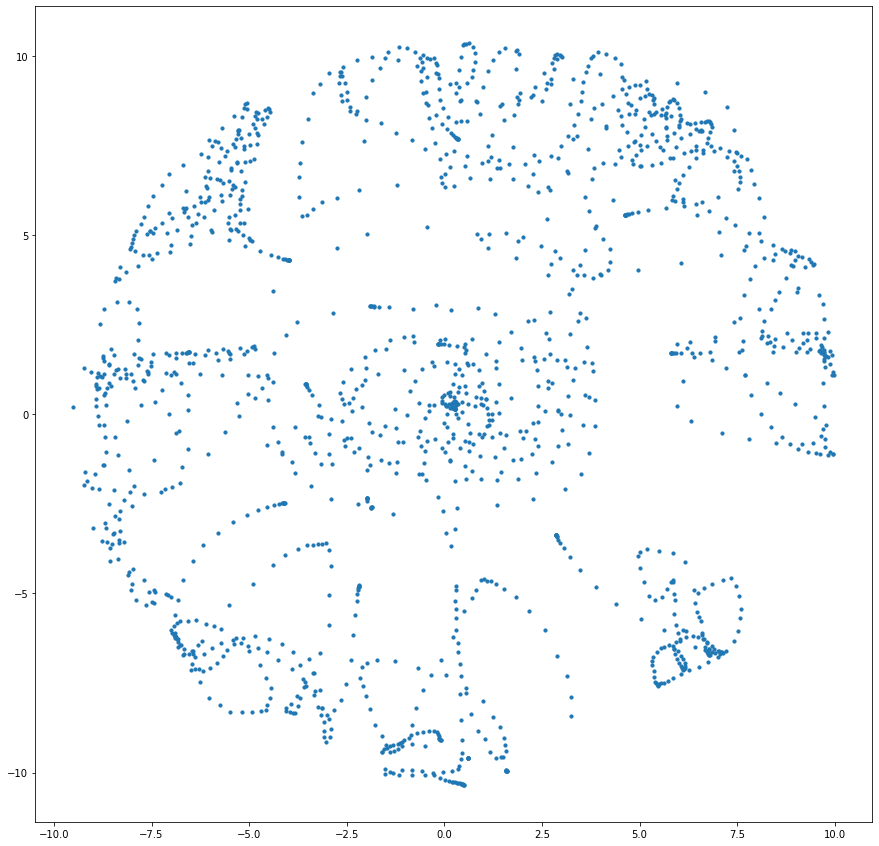

In [7]:
plot_data = np.array(Dataset.input_data).T[0:2].tolist()
plt.rcParams['figure.figsize'] = (15.0, 15.0)
fig, ax = plt.subplots()
ax.scatter(*plot_data, s=10)
plt.show()

# Аугментация

In [8]:
rang = 1.5
amount_augm_data = 10
augm_indata = []
augm_outdata = [] 
for inputd, outputd in zip(Dataset.input_data, Dataset.output_data):
  augm_indata.append(inputd)
  augm_outdata.append(outputd)
  for add in range(amount_augm_data):
    augm_indata.append([inputd[0]+random.uniform(-rang, rang),\
                               inputd[1]+random.uniform(-rang, rang),\
                               inputd[1]+random.uniform(-rang, rang)])
    augm_outdata.append(outputd);

# Данные после аугментации

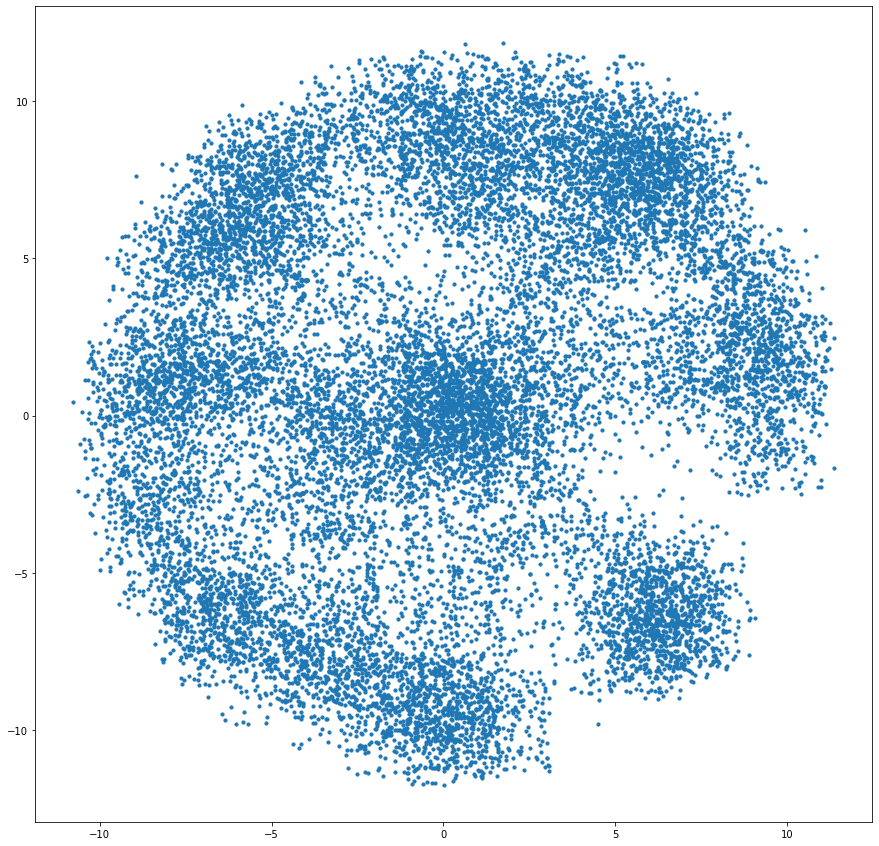

In [9]:
plot_data = np.array(augm_indata).T[0:2].tolist()
plt.rcParams['figure.figsize'] = (15.0, 15.0)
fig, ax = plt.subplots()
ax.scatter(*plot_data, s=10)
plt.show()

# Нормализация

In [10]:
norm_data = np.array(augm_indata)
max_x = norm_data[:, 0].max()
min_x = norm_data[:, 0].min()

max_y = norm_data[:, 1].max()
min_y = norm_data[:, 1].min()

max_z = norm_data[:, 2].max()
min_z = norm_data[:, 2].min()

norm_data -= np.array([min_x, min_y, min_z])
norm_data /= np.array([max_x - min_x, max_y - min_y, max_y - min_y])

# Разбиение по классам

In [11]:
df = pd.concat((pd.DataFrame(norm_data, columns=('x', 'y', 'z')),
                pd.DataFrame(augm_outdata, 
                columns=('pin12', 'pin13', 'pin14', 'pin15'))), axis=1)
df['x_lable'] = 'x'
df['-y_lable'] = '-y'
df['-x_lable'] = '-x'
df['y_lable'] = 'y'
df['lable'] = df['pin12'].astype(int) * df['x_lable'] +\
              df['pin13'].astype(int) * df['-y_lable'] +\
              df['pin14'].astype(int) * df['-x_lable'] +\
              df['pin15'].astype(int) * df['y_lable']

data_xy = []
mark_data = df[['x', 'y', 'lable']]
data_xy.append([*mark_data.loc[mark_data['lable'] == 'x-y-xy'][['x', 'y']].T.values.tolist(), 'x-y-xy'])
data_xy.append([*mark_data.loc[mark_data['lable'] == 'x'][['x', 'y']].T.values.tolist(), 'x'])
data_xy.append([*mark_data.loc[mark_data['lable'] == 'x-y'][['x', 'y']].T.values.tolist(), 'x-y'])
data_xy.append([*mark_data.loc[mark_data['lable'] == '-y'][['x', 'y']].T.values.tolist(), '-y'])
data_xy.append([*mark_data.loc[mark_data['lable'] == '-y-x'][['x', 'y']].T.values.tolist(), '-y-x'])
data_xy.append([*mark_data.loc[mark_data['lable'] == '-x'][['x', 'y']].T.values.tolist(), '-x'])
data_xy.append([*mark_data.loc[mark_data['lable'] == '-xy'][['x', 'y']].T.values.tolist(), '-xy'])
data_xy.append([*mark_data.loc[mark_data['lable'] == 'y'][['x', 'y']].T.values.tolist(), 'y'])
data_xy.append([*mark_data.loc[mark_data['lable'] == 'xy'][['x', 'y']].T.values.tolist(), 'xy'])
data_xy.append([*mark_data.loc[mark_data['lable'] == ''][['x', 'y']].T.values.tolist(), 'off'])

# Визуализация конечного датасета

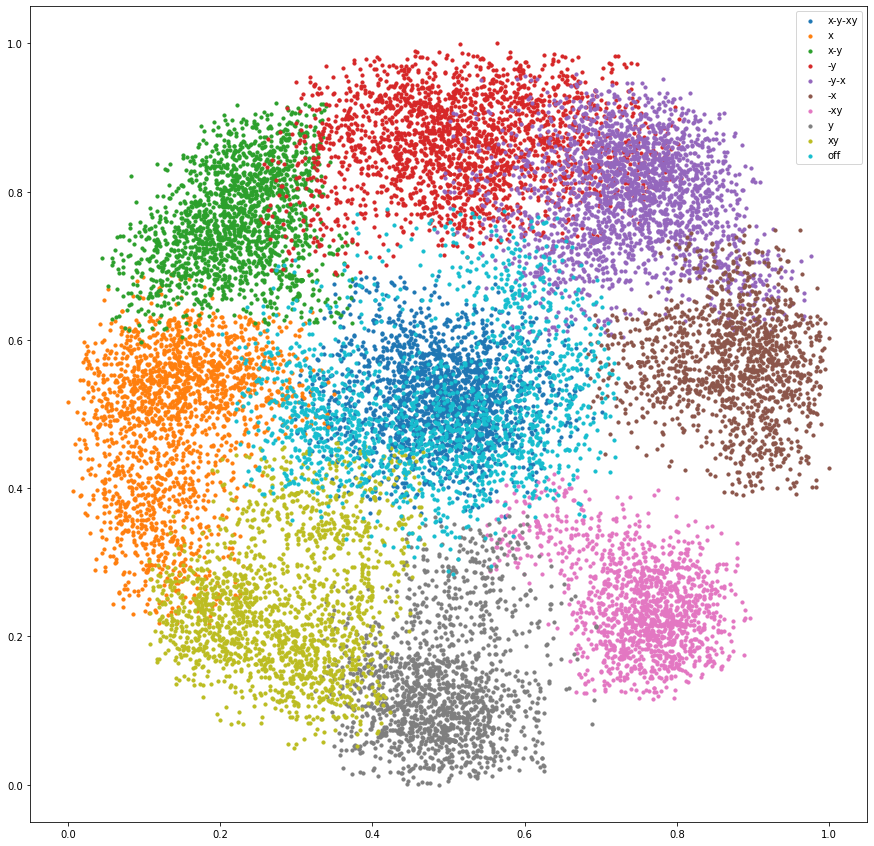

In [12]:
fig, ax = plt.subplots()
for data in data_xy:  
  ax.scatter(*data[0:2], s=10, label=data[2])

plt.legend()
plt.show()

# Обработка, в целом не нужная, я тут смотрем разные варианты, нужно выполнить

In [13]:
df = df[['x', 'y', 'z', 'pin12', 'pin13', 'pin14', 'pin15']]
clas = ['lall', 'lx', 'lx-y', 'l-y', 'l-y-x', 'l-x', 'l-xy', 'ly', 'lxy', 'loff']

df['lall'] = ((df['pin12']== 1.0) & (df['pin13']== 1.0) & (df['pin14']== 1.0) & (df['pin15']== 1.0)).astype(int)
df['lx'] = ((df['pin12']== 1.0) & (df['pin13']== 0.0) & (df['pin14']== 0.0) & (df['pin15']== 0.0)).astype(int)
df['lx-y'] = ((df['pin12']== 1.0) & (df['pin13']== 1.0) & (df['pin14']== 0.0) & (df['pin15']== 0.0)).astype(int)
df['l-y'] = ((df['pin12']== 0.0) & (df['pin13']== 1.0) & (df['pin14']== 0.0) & (df['pin15']== 0.0)).astype(int)
df['l-y-x'] = ((df['pin12']== 0.0) & (df['pin13']== 1.0) & (df['pin14']== 1.0) & (df['pin15']== 0.0)).astype(int)
df['l-x'] = ((df['pin12']== 0.0) & (df['pin13']== 0.0) & (df['pin14']== 1.0) & (df['pin15']== 0.0)).astype(int)
df['l-xy'] = ((df['pin12']== 0.0) & (df['pin13']== 0.0) & (df['pin14']== 1.0) & (df['pin15']== 1.0)).astype(int)
df['ly'] = ((df['pin12']== 0.0) & (df['pin13']== 0.0) & (df['pin14']== 0.0) & (df['pin15']== 1.0)).astype(int)
df['lxy'] = ((df['pin12']== 1.0) & (df['pin13']== 0.0) & (df['pin14']== 0.0) & (df['pin15']== 1.0)).astype(int)
df['loff'] = ((df['pin12']== 0.0) & (df['pin13']== 0.0) & (df['pin14']== 0.0) & (df['pin15']== 0.0)).astype(int)

df['level'] = df['lall']*0.1 + df['lx']*0.2 + df['lx-y']*0.3 + df['l-y']*0.4 +\
              df['l-y-x']*0.5 + df['l-x']*0.6 + df['l-xy']*0.7 +df ['ly']*0.8 + df ['lxy']*0.9 + df['loff'] * 1.0


# Перемешиваю датасет и разбиваю на train и validation

In [14]:
df = df.sample(frac=1)
indataset = df[['x', 'y', 'z']]
outdataset = df[clas]
size = indataset.shape[0]
train_dataset = np.array(indataset[0:int(size*0.7)])
train_lable = np.array(outdataset[0:int(size*0.7)])

valid_dataset = np.array(indataset[int(size*0.7):])
valid_lable = np.array(outdataset[int(size*0.7):])

#print(size)
#print(valid_dataset.shape)
#print(train_dataset.shape)

#print(valid_lable.shape)
#print(train_lable.shape)
#print(valid_dataset)
#valid_lable

In [15]:
from keras.callbacks import EarlyStopping
from keras.layers import InputLayer
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers
from keras import initializers
import tensorflow as tf

# Cоздание модели тестовый вариант

In [16]:
with tf.device('/cpu:0'):
  # Create neural networks model
  model = Sequential()
  # Add layers to the model
  model.add(Dense(4, activation='sigmoid',
                  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                  bias_initializer=initializers.RandomNormal(stddev=0.01), input_dim=3))      # first hidden layer
  model.add(Dense(20, activation='sigmoid',
                  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                  bias_initializer=initializers.RandomNormal(stddev=0.01)))                   # second hidden layer
  model.add(Dense(40, activation='sigmoid',
                  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                  bias_initializer=initializers.RandomNormal(stddev=0.01)))
  model.add(Dense(20, activation='sigmoid',
                  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                  bias_initializer=initializers.RandomNormal(stddev=0.01)))
  model.add(Dense(10, activation='softmax',
                  kernel_initializer=initializers.RandomNormal(stddev=0.01),
                  bias_initializer=initializers.RandomNormal(stddev=0.01)))                # output layer

# Обучение

In [17]:
with tf.device('/cpu:0'):
  # Compile the neural networks model
  #sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer='Adam', loss='categorical_crossentropy',  metrics=['acc'])
  # Train the neural networks model
  callbacks = [
    EarlyStopping(
        # Прекратить обучение если `val_loss` больше не улучшается
        monitor='val_loss',
        # "больше не улучшается" определим как "не лучше чем 1e-2 и меньше"
        min_delta=1e-3,
        # "больше не улучшается" далее определим как"
        patience=250,
        verbose=1)]

  history = model.fit(train_dataset, train_lable,
                      epochs=2000,
                      validation_data=(valid_dataset, valid_lable),
                      callbacks=callbacks)

Epoch 1/2000
395/395 [==============================] - 1s 2ms/step - loss: 2.2930 - acc: 0.1194 - val_loss: 2.2915 - val_acc: 0.1267
Epoch 2/2000
395/395 [==============================] - 0s 1ms/step - loss: 2.2919 - acc: 0.1238 - val_loss: 2.2908 - val_acc: 0.1267
Epoch 3/2000
395/395 [==============================] - 1s 1ms/step - loss: 2.2914 - acc: 0.1226 - val_loss: 2.2911 - val_acc: 0.1241
Epoch 4/2000
395/395 [==============================] - 1s 1ms/step - loss: 2.2913 - acc: 0.1257 - val_loss: 2.2904 - val_acc: 0.1267
Epoch 5/2000
395/395 [==============================] - 1s 1ms/step - loss: 2.2859 - acc: 0.1224 - val_loss: 2.2698 - val_acc: 0.1241
Epoch 6/2000
395/395 [==============================] - 1s 1ms/step - loss: 2.1929 - acc: 0.1250 - val_loss: 2.0739 - val_acc: 0.1448
Epoch 7/2000
395/395 [==============================] - 1s 1ms/step - loss: 1.9868 - acc: 0.2157 - val_loss: 1.9159 - val_acc: 0.2489
Epoch 8/2000
395/395 [==============================] - 0s 1ms

KeyboardInterrupt: ignored

# Бесмысленная штука, сюда нужно test часть выборки притащить

In [18]:
loss, acc = model.evaluate(valid_dataset,  valid_lable, verbose=2)
print(acc)

170/170 - 0s - loss: 1.3262 - acc: 0.4154
0.4154357314109802


# Графики

NameError: ignored

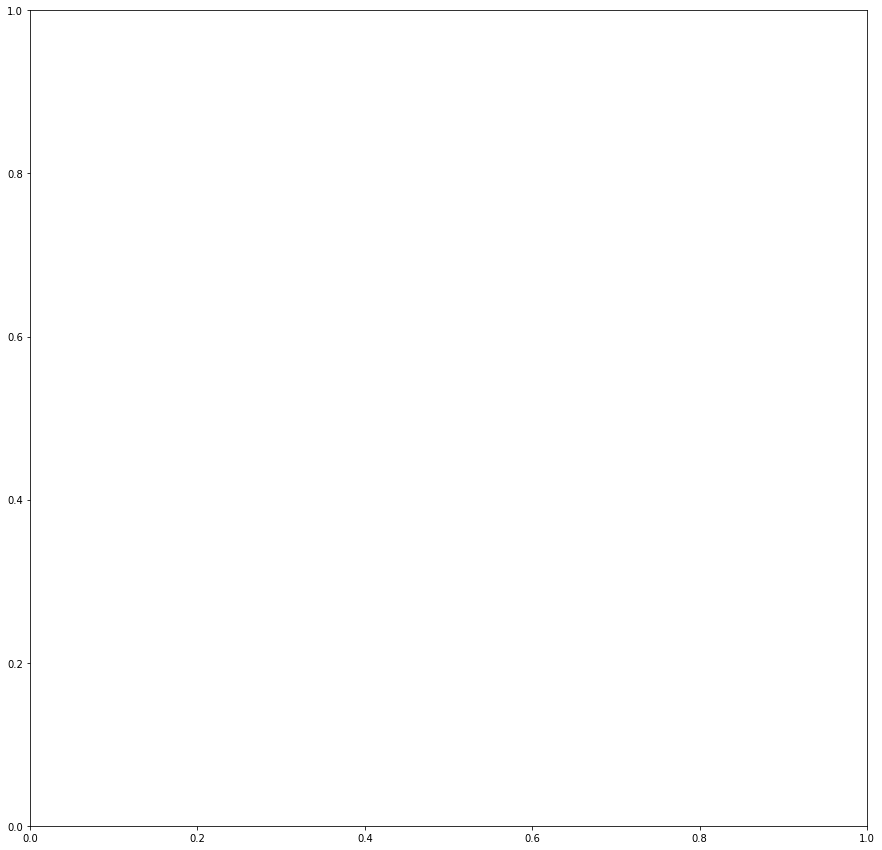

In [19]:
figaac, axaac = plt.subplots()
axaac.plot(history.history['acc'], label='accuracy')
axaac.plot(history.history['val_acc'], label='val_accuracy')

figaxloss, axloss = plt.subplots()  
axloss.plot(history.history['loss'], label='loss')
axloss.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

# Дальше пота что не готово

In [ ]:
def predict(xd, yd):
  levels = [x for x in range(1, 11)]
  y_predict = model.predict(np.array([[xd, yd, 0.0]]))[0]
  max = y_predict.max()
  for i, dat in enumerate(y_predict):
    y_predict[i] = 1 if (dat == max) else 0
  return (y_predict*levels).sum()

print(predict(1., 1.))

5.0


In [ ]:
def cls_function(z, step_grid predict_foo)
  xx, yy = np.meshgrid(np.arange(0, 1.2, step_grid), np.arange(0, 1.2, step_grid))
  Z = np.zeros(xx.shape)
  for i, line in enumerate(zip(xx, yy)):
    for j, items in enumerate(zip(*line)):
      Z[i][j] = predict_foo(*items)
  return Z

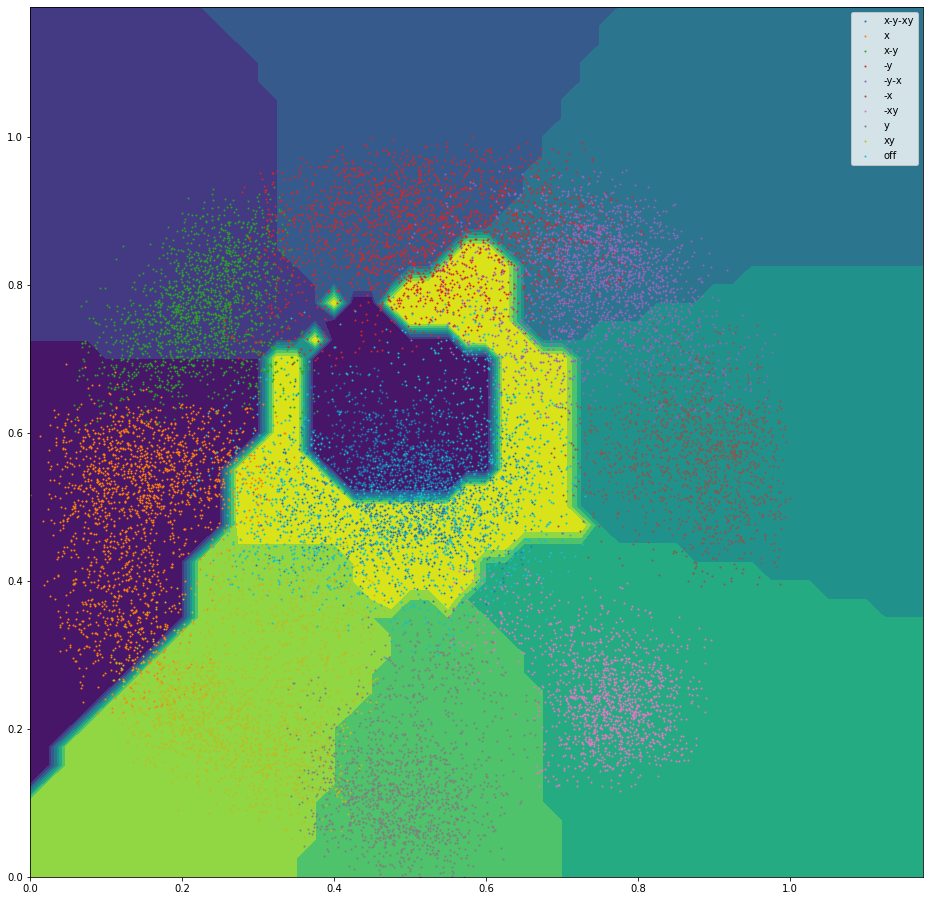

In [ ]:


fig, ax = plt.subplots()
ax.contourf(xx, yy, Z, levels = 10)
for data in data_xy:  
  ax.scatter(*data[0:2], s=1, label=data[2])
fig.set_figwidth(16)
fig.set_figheight(16)
plt.legend()
plt.show()